### Capstone ###
For my capstone project I wanted to look at a real world problem I encountered while working in teaching. Lots of low-income students enter college without the necessary skills to graduate and wind up with lots of student debt and nothing to show for it. I found my data from the National Center for Education Statistics, and attempted to predict which students would drop out of college. 

In [2]:
#importing things
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import patsy
from sklearn.model_selection import GridSearchCV
%matplotlib inline
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 5000
tqdm.pandas(desc='progress-bar')

In [3]:
#reading in the data
df = pd.read_csv("/Users/rowan/Desktop/els_02_12_byf3pststu_v1_0.csv")

/Users/rowan/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1222) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.shape

(16197, 4012)

## Variable Selection

In [5]:
df = df.loc[:, (df != -5).any(axis=0)]
#getting rid of columns which are restricted as denoted by all values = -5

In [6]:
#successfully got rid of 1000 columns this way
df.shape

(16197, 3084)

In [7]:
#thanks nick
#using regex to get rid of columns which are just indicating imputed values in another column
#since I'm not going to reimpute columns this isn't relevant
clms = df.columns
new_clms = [x for x in clms if not re.search(r'IM$', x)]
df = df[new_clms]

In [14]:
#getting rid of all of the columns from the 3rd survey because im not looking for follow up data
clmns = df.columns
new_clmns = [x for x in clmns if not re.search(r'^F3', x)]
new_clmns.append('F3ATTAINMENT')
data = df[new_clmns]

In [15]:
#this only got rid of about 40 columns
data.shape

(16197, 2575)

In [16]:
#filtering the dataframe so it's only those who ever attended college (this removed about 6000 students)
data = data[data.F2EVRATT==1]
data = data[data.F3ATTAINMENT > 2]

In [17]:
#making this into a binary class, graduated or did not graduate
data.loc[data.F3ATTAINMENT == 3 , "F3ATTAINMENT"] = 0
data.loc[data.F3ATTAINMENT == 4 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 5 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 6 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 7 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 8 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 9 , "F3ATTAINMENT"] = 1
data.loc[data.F3ATTAINMENT == 10 , "F3ATTAINMENT"] = 1

In [18]:
#getting values which are correlated with students finishing college, positively or negatively
c = data.corr().abs()
d = c[c.F3ATTAINMENT > 0.25]

In [19]:
#filtering my data frame so its now only those columns so I don't need to look at the corr for those
#variables with all my columns
my_cols = d.index
data = data[my_cols]

In [20]:
#renaming columns so they mean something
data.rename(columns={'F2PSYR1':'Mon_Enr_After_HS', 'F2PSMO45':'Mon_Enr_in_05', 'F2PS2006':"Num_Col_Att", 
                    'F2PSEJ06':'Type_Col_Att', 'F2PTN1PS':'When_Att_Col', 'F2PTN2PS':'Int_Col_Att',
                    'F2PSPPLN':'Pipeline', 'F2C13':'Employment', 'F2C20':'Type_of_Emp',
                    'F2D07':'Home_in_College', 'F3ATTAINMENT':'Graduated'}, inplace=True)

In [21]:
#dropping columns which are highly correlated or have tons of missing values
data.drop(['F2B29A', 'F2B29B', 'F2B29C', 'F2B29D', 'F2B29E', 'F2B29F', 'F2B29G',
          'F2B29H', 'F2B29I', 'F2B29J', 'F2B29K', 'F2C17P2', 'F2C18P', 
          'F2C22A', 'F2C22B', 'F2C22C', 'F2C22D', 'F2C23','F2RTYPE'], axis=1, inplace=True)

In [22]:
#getting the shape of the df to see how many variables I have left
data.shape

(9314, 11)

In [23]:
#replacing my negative values (non-responses with 0s so they weight less)
#https://stackoverflow.com/questions/27759084/how-to-replace-negative-numbers-in-pandas-data-frame-by-zero
data[data < 0] = 0

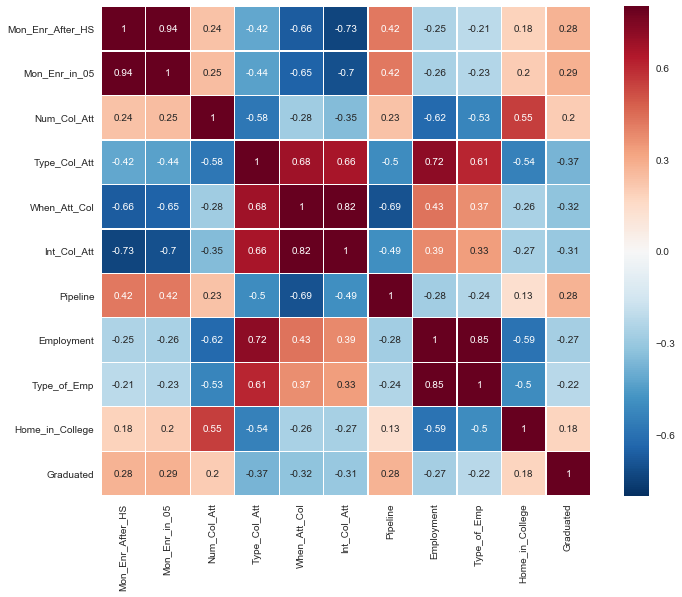

In [24]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, linewidths = 0.4, annot = True)

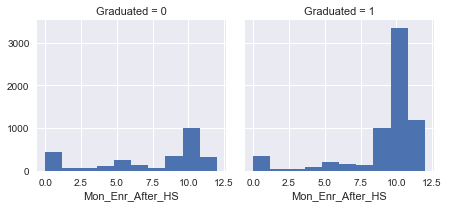

In [25]:
#this shows that people who were enrolled full time after HS tend to be more likely to graduate
g = sns.FacetGrid(data, col="Graduated", col_wrap=4)
g = (g.map(plt.hist, "Mon_Enr_After_HS"))

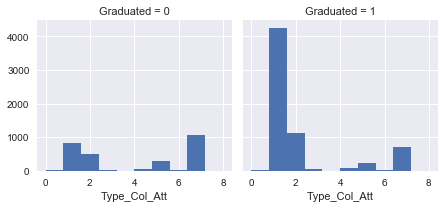

In [26]:
#shows that people who are enrolled full time at school, as denoted by 1/2/3 are more likely to graduate
g = sns.FacetGrid(data, col="Graduated", col_wrap=4)
g = (g.map(plt.hist, "Type_Col_Att"))

In [27]:
#just getting the correlation with those variables so there's less to look at 
cor = data.corr().abs()
#turning it into a list so it's easier to look at
t = cor.unstack()
st = t.sort_values(kind="quicksort")
print st[:]

Pipeline          Home_in_College     0.132152
Home_in_College   Pipeline            0.132152
Graduated         Home_in_College     0.179255
Home_in_College   Graduated           0.179255
                  Mon_Enr_After_HS    0.184149
Mon_Enr_After_HS  Home_in_College     0.184149
Mon_Enr_in_05     Home_in_College     0.201788
Home_in_College   Mon_Enr_in_05       0.201788
Num_Col_Att       Graduated           0.202365
Graduated         Num_Col_Att         0.202365
Mon_Enr_After_HS  Type_of_Emp         0.213933
Type_of_Emp       Mon_Enr_After_HS    0.213933
                  Graduated           0.219525
Graduated         Type_of_Emp         0.219525
Mon_Enr_in_05     Type_of_Emp         0.232570
Type_of_Emp       Mon_Enr_in_05       0.232570
Pipeline          Num_Col_Att         0.233371
Num_Col_Att       Pipeline            0.233371
                  Mon_Enr_After_HS    0.235644
Mon_Enr_After_HS  Num_Col_Att         0.235644
Type_of_Emp       Pipeline            0.242530
Pipeline     

In [28]:
def eda(dataframe): #Ritkas code chunk to check quality of data
    print "missing values \n", dataframe.isnull().sum() #shows total amount of null values for each column
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape     
    print "dataframe describe \n", dataframe.describe()
    print "dataframe length =", len(dataframe) #length of the dataframe
    print "duplicates", dataframe.duplicated().sum() # added this to duplicates in the data
    for item in dataframe:
        print item
        print dataframe[item].nunique()
        
eda(data)

missing values 
Mon_Enr_After_HS    0
Mon_Enr_in_05       0
Num_Col_Att         0
Type_Col_Att        0
When_Att_Col        0
Int_Col_Att         0
Pipeline            0
Employment          0
Type_of_Emp         0
Home_in_College     0
Graduated           0
dtype: int64
dataframe types 
Mon_Enr_After_HS    int64
Mon_Enr_in_05       int64
Num_Col_Att         int64
Type_Col_Att        int64
When_Att_Col        int64
Int_Col_Att         int64
Pipeline            int64
Employment          int64
Type_of_Emp         int64
Home_in_College     int64
Graduated           int64
dtype: object
dataframe shape 
(9314, 11)
dataframe describe 
       Mon_Enr_After_HS  Mon_Enr_in_05  Num_Col_Att  Type_Col_Att  \
count       9314.000000    9314.000000   9314.00000   9314.000000   
mean           8.552609       8.727614      0.99184      2.616921   
std            3.185903       3.261632      0.61874      2.358395   
min            0.000000       0.000000      0.00000      0.000000   
25%            9.00

## Modeling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = patsy.dmatrix('~ (Mon_Enr_After_HS) + (Mon_Enr_in_05) + (Num_Col_Att) + (Type_Col_Att) + (When_Att_Col) + (Int_Col_Att) + (Pipeline) + (Employment) + (Type_of_Emp) + (Home_in_College) + (Mon_Enr_After_HS:Mon_Enr_in_05) + (Employment:Type_of_Emp) + (Int_Col_Att:When_Att_Col)', data)
X = pd.DataFrame(X, columns=X.design_info.column_names)
y = data.Graduated

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
print logreg.score(X_test,y_test)

cm = np.array(confusion_matrix(Y_pred, y_test, labels=[True,False]))
names = ['ACTUAL YES', 'ACTUAL NO', 'PREDICTED YES', 'PREDICTED NO']
confusion = pd.DataFrame(cm, index=names[:2], columns=names[2:])
    
print "Confusion Matrix:"
print confusion

0.747234873129
Confusion Matrix:
            PREDICTED YES  PREDICTED NO
ACTUAL YES           1934           556
ACTUAL NO             221           363


In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

def do_cross_val(model):
    scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
    return scores.mean(), scores.std()

bdt = BaggingClassifier(DecisionTreeClassifier())

do_cross_val(bdt)


(0.7237519765077931, 0.015204774310133673)

In [31]:
brf = BaggingClassifier(RandomForestClassifier())
do_cross_val(brf)

(0.72589893648898463, 0.016902383967014035)

In [32]:
def Super_Fit_Models():
    X = patsy.dmatrix('~ (Mon_Enr_After_HS) + (Mon_Enr_in_05) + (Num_Col_Att) + (Type_Col_Att) + (When_Att_Col) + (Int_Col_Att) + (Pipeline) + (Employment) + (Type_of_Emp) + (Home_in_College) + (Mon_Enr_After_HS:Mon_Enr_in_05) + (Employment:Type_of_Emp) + (Int_Col_Att:When_Att_Col)', data)
    X = pd.DataFrame(X, columns=X.design_info.column_names)
    y = data.Graduated
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
  # prepare configuration for cross validation test harness
    seed = 7
  # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    models.append(('RF', RandomForestClassifier()))
  # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
  # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR: 0.752404 (0.016534)
LDA: 0.751442 (0.018681)


/Users/rowan/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


KNN: 0.712821 (0.021877)
CART: 0.723878 (0.019205)
NB: 0.743269 (0.017669)
SVM: 0.741186 (0.018078)
RF: 0.726763 (0.017777)


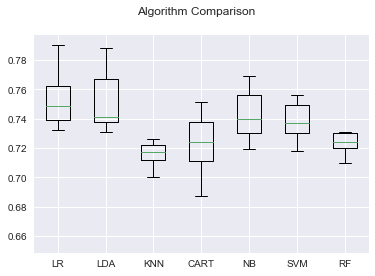

In [33]:
Super_Fit_Models()

In [34]:
parameters = {
    'penalty': ('l1', 'l2'),
    'C': (0.001,0.01,0.1,1,10),
    'class_weight': ('balanced', {0:2,1:3}, None)
}
logreg = LogisticRegression()
clf = GridSearchCV(logreg, parameters)
clf.fit(X,y)
clf.best_estimator_.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [36]:
clf.best_score_

0.74189392312647628

In [37]:
logreg = LogisticRegression().fit(X_train,y_train)
Y_pred = logreg.predict(X_test)

In [38]:
gslogreg = LogisticRegression(C=10).fit(X_train,y_train)
coef = pd.DataFrame(np.exp(gslogreg.coef_))
coef.columns = X.columns
coef = coef.T
coef

,0
Intercept,1.301810
Mon_Enr_After_HS,1.015884
Mon_Enr_in_05,1.050430
Num_Col_Att,0.902471
Type_Col_Att,0.813017
When_Att_Col,0.947869
Int_Col_Att,0.830309
Pipeline,1.113877
Employment,0.647855
Type_of_Emp,1.029199


### Conclusions ###
I found that the most important factor in determining whether or not a student will graduate is the kind of school they went to and when they entered school. Students who entered school full-time were more likely to graduate than students who only went to school part time and students who went to for-profit colleges were less likely to graduate than students who went to non-profit schools. The federal government has been cracking down on for-profit schools for a while, which is good, and should continue as most students who attend them will not graduate. 
My next step to further this project is to get the non-restricted data set so I can get demographic information as I believe that would be a very good predictor and be more meaningful.